In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from kornia.filters import SpatialGradient

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [3]:
# # # Dataloader
class dataset(Dataset):
    def __init__(self, dir_path, csv_file):
        super(Dataset, self).__init__()

        self.dir_path = dir_path
        self.csv_file = pd.read_csv(csv_file,index_col=0)

        self.output = self.csv_file['y_number']

        self.transform = transforms.Compose([
    transforms.ToTensor()
])

    def __len__(self):
        return self.csv_file.shape[0]
        
    def __getitem__(self, index):

        # Get the indice for the output wavefield
        self.output_im = self.output.astype(int)[index]

        inputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in range(self.output_im-4,self.output_im)]
        #print(list(im for im in range(self.output_im-4,self.output_im))) # For debugging

        outputs = [cv2.imread(self.dir_path + f'Simple_Homogeneous_Moseley_Event0000_{im}.tiff',cv2.IMREAD_UNCHANGED) for im in [self.output_im]]
        #print(list(im for im in [self.output_im])) # For debugging

        inputs = self.transform(np.array(inputs))
        outputs = self.transform(np.array(outputs))
        sample = {"wave_input": inputs,
                    "wave_input_label":self.output_im,
                    "wave_output": outputs,
                    "wave_output_label":self.output_im}
        return sample

### Test Dataset

In [6]:
training_data = dataset('../../Simple_Homogeneous_Moseley/','../../Simple_Homogeneous_Moseley_Event0000_Continuous.csv')

In [7]:
sample = training_data.__getitem__(0)

In [8]:
x_4 = sample['wave_input'].transpose(1, 0)[:,::4,::4]
x_2 = sample['wave_input'].transpose(1, 0)[:,::2,::2]
x_1 = sample['wave_input'].transpose(1, 0)

gt = sample['wave_output'].transpose(1, 0)[None]

Text(0.5, 1.0, 'Output - Wavefield 10')

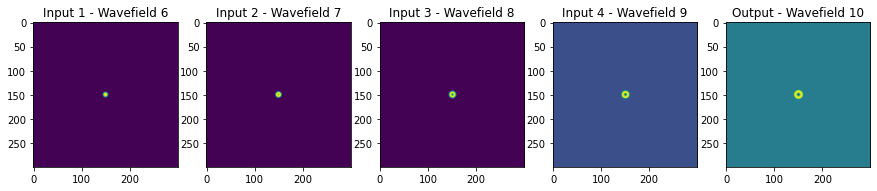

In [9]:
# # # Plot
fig, axs = plt.subplots(1,5,figsize=(15,3))

axs = axs.ravel()
for _i, ax in enumerate(axs[:-1]):
    ax.imshow(sample['wave_input'].transpose(1, 0).detach().numpy()[_i,:,:])

    wavefield = sample['wave_output_label'] - 4 + _i

    ax.set_title(f'Input {_i+1} - Wavefield {wavefield}')

axs[-1].imshow(sample['wave_output'].transpose(1, 0).detach().numpy()[0,:,:])
axs[-1].set_title('Output - Wavefield {}'.format(sample['wave_output_label']))

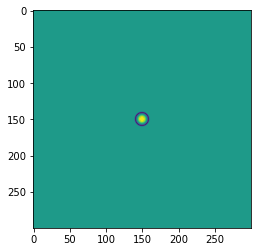

In [10]:
plt.imshow(sample['wave_input'].transpose(1, 0).detach().numpy()[3,:,:]-sample['wave_output'].transpose(1, 0).detach().numpy()[0,:,:])

### Test Dataloader

In [11]:
dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [12]:
samples = next(iter(dataloader))
samples['wave_input'].transpose(2, 1).size()

torch.Size([16, 4, 300, 300])

In [13]:
class ConvBlock(nn.Module): 
    def __init__(self,in_channels): 
        super(ConvBlock, self).__init__()

        self.convblock = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.convblock(x)
        return x

In [14]:
class MultiScale(nn.Module):
    def __init__(self,in_channels): 
        super(MultiScale, self).__init__()

        self.convblock_1 = ConvBlock(in_channels=in_channels)
        self.convblock_2 = ConvBlock(in_channels=in_channels+1)
        self.convblock_3 = ConvBlock(in_channels=in_channels+1)

        self.upsample = nn.Upsample(scale_factor=(2,2))

    def forward(self,x_4,x_2,x_1):

        x = self.convblock_1(x_4)
        x = self.upsample(x)

        x = self.convblock_2(torch.cat((x,x_2),dim=1))
        x = self.upsample(x)

        x = self.convblock_2(torch.cat((x,x_1),dim=1))

        return x

In [15]:
model = MultiScale(in_channels=4)

In [16]:
gen = model(x_4[None],x_2[None],x_1[None])

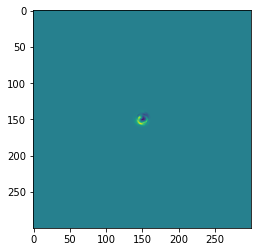

In [17]:
plt.imshow(gen[0,0].detach().numpy())

In [98]:
# # # Training
dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

model = MultiScale(in_channels=4)
model = model.to(device)

criterion = MSLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200

In [99]:
for epoch in range(epochs):
    
    train_loss = 0
    train_loss_l2 = 0
    train_loss_gdl = 0

    model.train()

    for samples in dataloader:

        wave_input = samples['wave_input'].transpose(2, 1)
        wave_input = wave_input.to(device)
        wave_input.require_grad = True

        #print(wave_input.size()) # For debugging

        x_4 = wave_input[:,:,::4,::4]
        x_2 = wave_input[:,:,::2,::2]
        x_1 = wave_input

        #print(x_4.size()) # For debugging
        #print(x_2.size()) # For debugging
        #print(x_1.size()) # For debugging
 
        gt = samples['wave_output'].transpose(2, 1)
        gt = gt.to(device)

        optimizer.zero_grad()

        gen = model(x_4,x_2,x_1)

        loss, loss_l2, loss_gdl = criterion(gen, gt)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * samples['wave_input'].size(0)
        train_loss_l2 += loss_l2.item() * samples['wave_input'].size(0)
        train_loss_gdl += loss_gdl.item() * samples['wave_input'].size(0)

    epoch_loss = train_loss / training_data.__len__()
    epoch_loss_l2 = train_loss_l2 / training_data.__len__()
    epoch_loss_gdl = train_loss_gdl / training_data.__len__()
    
    print('Epoch : %d, Loss : %.5e, Loss L2: %.5e, Loss GDL: %.5e' % (epoch,epoch_loss,epoch_loss_l2,epoch_loss_gdl))

Epoch : 0, Loss : 2.98632e+00, Loss L2: 2.56604e+00, Loss GDL: 4.20271e-01
Epoch : 1, Loss : 2.15657e-01, Loss L2: 1.58911e-01, Loss GDL: 5.67462e-02
Epoch : 2, Loss : 9.62348e-02, Loss L2: 6.92591e-02, Loss GDL: 2.69757e-02
Epoch : 3, Loss : 5.69315e-02, Loss L2: 4.17804e-02, Loss GDL: 1.51511e-02
Epoch : 4, Loss : 3.90259e-02, Loss L2: 2.82671e-02, Loss GDL: 1.07588e-02
Epoch : 5, Loss : 3.36292e-02, Loss L2: 2.48996e-02, Loss GDL: 8.72966e-03
Epoch : 6, Loss : 2.56507e-02, Loss L2: 1.83680e-02, Loss GDL: 7.28270e-03
Epoch : 7, Loss : 2.48281e-02, Loss L2: 1.83672e-02, Loss GDL: 6.46089e-03
Epoch : 8, Loss : 2.14572e-02, Loss L2: 1.56824e-02, Loss GDL: 5.77473e-03
Epoch : 9, Loss : 1.83976e-02, Loss L2: 1.33336e-02, Loss GDL: 5.06393e-03
Epoch : 10, Loss : 1.77527e-02, Loss L2: 1.30220e-02, Loss GDL: 4.73069e-03
Epoch : 11, Loss : 1.84388e-02, Loss L2: 1.40062e-02, Loss GDL: 4.43260e-03
Epoch : 12, Loss : 1.47268e-02, Loss L2: 1.07283e-02, Loss GDL: 3.99852e-03
Epoch : 13, Loss : 1.4

In [100]:
# # # Save model
dir_save = 'MULSTISCALE_L2_GDL/'
model_name = f'L2_GDL_E{epochs}'

if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

PATH = dir_save + model_name + '.pt'
torch.save(model.state_dict(), PATH)

In [18]:
# # # Load model
epochs = 1000
dir_save = 'MULSTISCALE_L2_GDL/'
model_name = f'L2_GDL_E{epochs}'

PATH = dir_save + model_name + '.pt'

model_test = MultiScale(in_channels=4)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

MultiScale(
  (convblock_1): ConvBlock(
    (convblock): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (convblock_2): ConvBlock(
    (convblock): Sequential(
      (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (convblock_3): ConvBlock(
    (convblock): Sequential(
      (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [19]:
# # # Testing - One sample
time_step = 10

test_sample = training_data.__getitem__(time_step)

test_x = test_sample['wave_input'].transpose(1, 0)
test_x = test_x.to('cpu')
model = model_test.to('cpu')

x_4 = test_x[:,::4,::4]
x_2 = test_x[:,::2,::2]
x_1 = test_x

test_gen = model(x_4[None],x_2[None],x_1[None])

test_gt = test_sample['wave_output'].transpose(1, 0)[None]

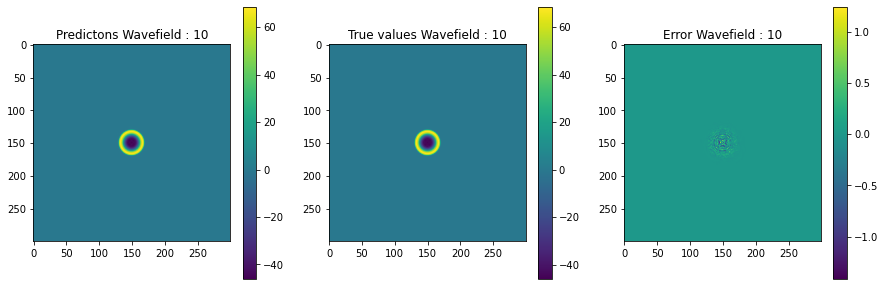

In [20]:
# # # Plot Testing - One Sample

pred = test_gen[0,0].detach().cpu().numpy()
true = test_gt[0,0].detach().cpu().numpy()
error = pred - true

fig , ax = plt.subplots(1,3,figsize=(15,5))
im = ax[0].imshow(pred)
ax[0].set_title(f'Predictons Wavefield : {time_step}')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(true)
ax[1].set_title(f'True values Wavefield : {time_step}')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(error)
ax[2].set_title(f'Error Wavefield : {time_step}')
plt.colorbar(im, ax=ax[2])


In [21]:
import time

In [22]:
# # # Testing - Recursive Testing

# Parameters
initial_timestep = 20
number_of_timestep_to_predict = 170
timestep_to_plot = [0,25,50,100,150]

# Inputs
initial_test_sample = training_data.__getitem__(initial_timestep)
test_x = initial_test_sample['wave_input'].transpose(1, 0)[None]
test_x = test_x.to('cpu')

model = model.to('cpu')

# Store the outputs
preds = np.zeros((len(timestep_to_plot),300,300))
trues = np.zeros((len(timestep_to_plot),300,300))
norms = []

start_time = time.time()

im = 0
for ts in range(number_of_timestep_to_predict):
    x_4 = test_x[:,:,::4,::4]
    x_2 = test_x[:,:,::2,::2]
    x_1 = test_x

    # Predicted wavefield
    test_gen = model(x_4,x_2,x_1)
    pred = test_gen[0,0].detach().cpu().numpy()

    # True wavefield
    test_gt = training_data.__getitem__(initial_timestep+ts)['wave_output'].transpose(1, 0)[None]
    true = test_gt[0,0].detach().cpu().numpy()

    # Store selected wavefield
    if ts in timestep_to_plot:
        print(f"Saving wavefield {ts}")
        preds[im,:,:] = pred
        trues[im,:,:] = true
        im += 1

    # Update wavefield
    test_x = torch.cat((test_x,test_gen),dim=1)[:,1:,:,:] # Concat gen wavefield as the new input wavefield

    # Save norm
    norms.append(np.linalg.norm(true-pred))
end_time = time.time()

total_time = end_time - start_time

print(f'\nTotal time for the predictions [s] for {number_of_timestep_to_predict} timesteps :',np.round(total_time,2))

errors = preds - trues

Saving wavefield 0
Saving wavefield 25
Saving wavefield 50
Saving wavefield 100
Saving wavefield 150

Total time for the predictions [s] for 170 timesteps : 98.7


In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 0.98, 'Initital timestep : 20')

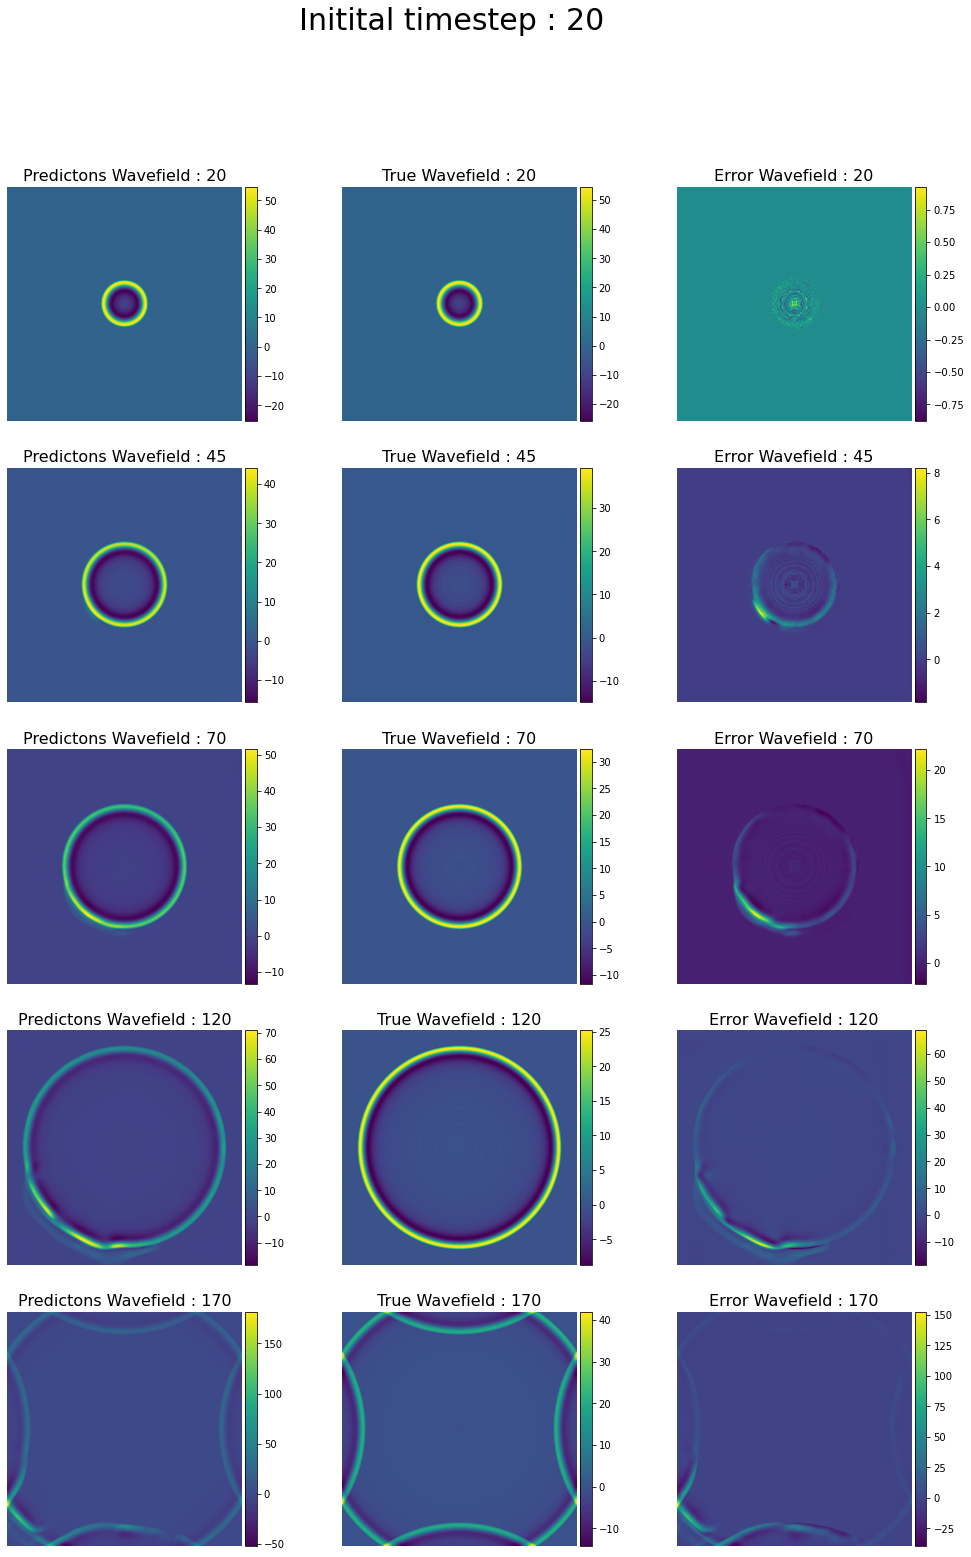

In [24]:
# # # Plot testing - multiple sample

fig , axs = plt.subplots(len(timestep_to_plot),3,figsize=(17,len(timestep_to_plot)*5))

for row, ts in enumerate(timestep_to_plot):

    im = axs[row,0].imshow(preds[row,:,:])

    divider = make_axes_locatable(axs[row,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,0].axis('off')
    axs[row,0].set_title(f'Predictons Wavefield : {initial_timestep + ts}',fontsize=16)

    im = axs[row,1].imshow(trues[row,:,:])

    divider = make_axes_locatable(axs[row,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,1].axis('off')
    axs[row,1].set_title(f'True Wavefield : {initial_timestep + ts}',fontsize=16)

    im = axs[row,2].imshow(errors[row,:,:])

    divider = make_axes_locatable(axs[row,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[row,2].axis('off')
    axs[row,2].set_title(f'Error Wavefield : {initial_timestep + ts}',fontsize=16)

fig.suptitle(f'Initital timestep : {initial_timestep}', fontsize=30)


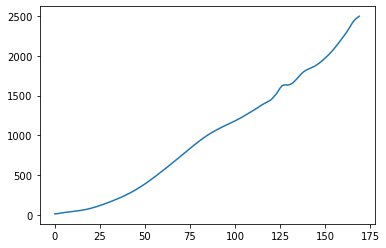

In [25]:
plt.plot(norms)